# Loading the data / Data Understanding
Following CRISP-ML best practices...

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/LoanData.csv')

# Display the first few rows of the dataset
df.head()

/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_39395/232191720.py:6: DtypeWarning: Columns (10,56,73,74,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/LoanData.csv')


,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,...,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory,LoanCancelled,PreviousEarlyRepaymentsBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,3015853,2022-09-09 12:27:01,2022-09-09 15:27:01,11.0,0.0,88.0,False,2022-09-09 15:15:03,2022-09-09,...,NaN,2024-05-27,6.0,23.0,2023-11-30,NaN,NaN,NaN,NaN,NaN
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,3743447,2023-05-19 11:04:33,2023-05-19 14:04:33,0.0,0.0,0.0,False,2023-05-19 14:03:54,2023-05-19,...,NaN,2024-05-27,11.0,120.0,2023-07-20,NaN,NaN,91-120,NaN,NaN
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,4335414,2024-02-03 14:43:32,2024-02-03 16:43:32,0.0,0.0,0.0,False,2024-02-03 16:41:51,2024-02-03,...,NaN,2024-07-08,2.0,12.0,2024-05-12,NaN,NaN,NaN,NaN,NaN
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970.0,1150.0,5.0,False,2016-03-17 12:39:22,2016-03-23,...,2020-01-27,NaN,NaN,NaN,NaN,0.0,82.76,180+,NaN,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,4043783,2023-09-26 12:14:12,2023-09-26 15:14:12,0.0,0.0,0.0,False,2023-09-26 15:13:07,2023-09-26,...,NaN,2024-06-04,9.0,108.0,NaN,NaN,NaN,16-30,NaN,NaN


In [84]:
# What columns are causing the warning?
flagged_indices = [10, 56, 73, 74, 94, 95]
flagged_columns = df.columns[flagged_indices]

# Display the columns causing the warning, their types, and an example value with index
for col in flagged_columns:
    print(f"\nColumn: {col}")
    col_types = df[col].map(type)
    for t in col_types.unique():
        example_series = df[col][col_types == t]
        example_index = example_series.index[0]
        example_value = example_series.iloc[0]
        print(f"Type: {t.__name__}, Example: {example_value}, Index: {example_index}")


Column: ContractEndDate
Type: str, Example: 2025-10-27, Index: 0
Type: float, Example: nan, Index: 4

Column: DefaultDate
Type: float, Example: nan, Index: 0
Type: str, Example: 2020-01-14, Index: 3

Column: CreditScoreEsEquifaxRisk
Type: float, Example: nan, Index: 0
Type: str, Example: B, Index: 14

Column: CreditScoreFiAsiakasTietoRiskGrade
Type: float, Example: nan, Index: 0
Type: str, Example: 3, Index: 1

Column: ActiveLateLastPaymentCategory
Type: float, Example: nan, Index: 0
Type: str, Example: 91-120, Index: 1

Column: LoanCancelled
Type: float, Example: nan, Index: 0
Type: bool, Example: False, Index: 389970


These dates are specified as follows as per the API documentation (https://api.bondora.com/doc/ResourceModel?modelName=PublicDatasetItem&v=1):

- ContractEndDate = Date
- DefaultDate = Date
- CreditScoreEsEquifaxRisk = string
- CreditScoreFiAsiakasTietoRiskGrade = string
- ActiveLateLastPaymentCategory = string
- LoanCancelled = boolean

The warning is due to the fact that these columns are not being read in as the correct data types. Should be handled in the data preparation step.

In [85]:
# Show basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400170 entries, 0 to 400169
Data columns (total 97 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   LoanId                                  400170 non-null  object 
 1   LoanNumber                              400170 non-null  int64  
 2   ListedOnUTC                             400170 non-null  object 
 3   BiddingStartedOn                        400170 non-null  object 
 4   BidsPortfolioManager                    400170 non-null  float64
 5   BidsApi                                 400170 non-null  float64
 6   BidsManual                              400170 non-null  float64
 7   NewCreditCustomer                       400170 non-null  bool   
 8   LoanApplicationStartedDate              400170 non-null  object 
 9   LoanDate                                400170 non-null  object 
 10  ContractEndDate                         1030

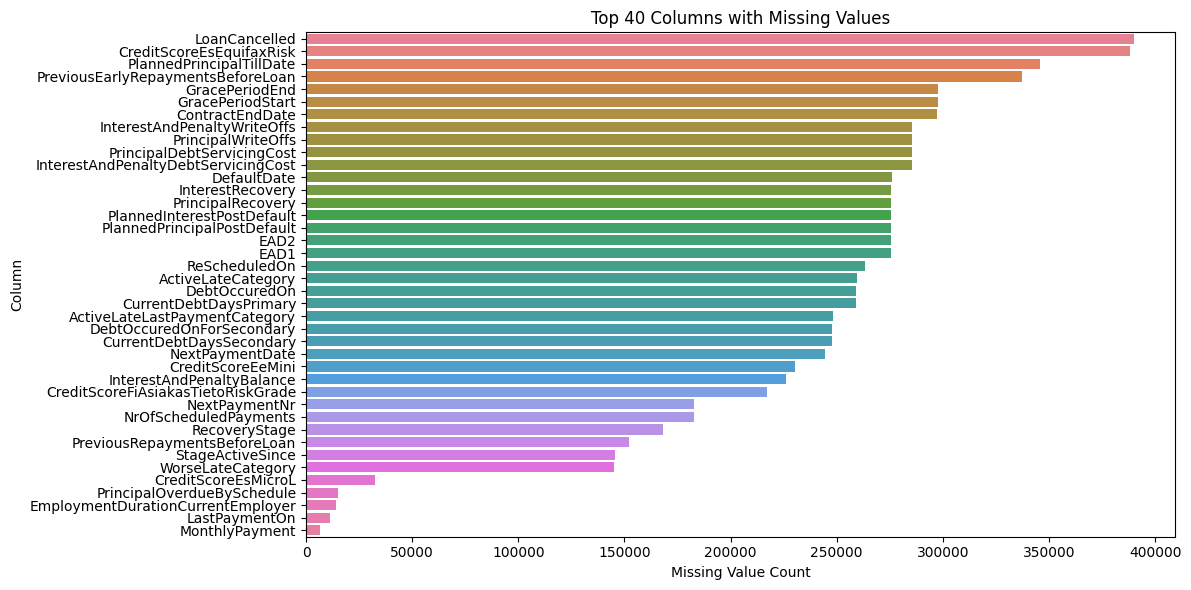

,Column,MissingCount
0,LoanCancelled,389970
1,CreditScoreEsEquifaxRisk,387951
2,PlannedPrincipalTillDate,345706
3,PreviousEarlyRepaymentsBeforeLoan,337407
4,GracePeriodEnd,297894
5,GracePeriodStart,297894
6,ContractEndDate,297158
7,InterestAndPenaltyWriteOffs,285617
8,PrincipalWriteOffs,285617
9,PrincipalDebtServicingCost,285617


In [86]:
# Check for missing values across all columns
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

# Create a DataFrame from the Series
missing_df = missing_values.reset_index()
missing_df.columns = ['Column', 'MissingCount']

# Plot the missing values
plt.figure(figsize=(12, 6))
sns.barplot(
    data=missing_df.head(40),
    x='MissingCount',
    y='Column',
    hue='Column',
    legend=False,
)
plt.title("Top 40 Columns with Missing Values")
plt.xlabel("Missing Value Count")
plt.ylabel("Column")
plt.tight_layout()
plt.show()

# Display the DataFrame of missing values
missing_df

In [87]:
# Check the number of unique values in each column
unique_counts = df.nunique().sort_values(ascending=False)
unique_counts

LoanId                               400170
LoanNumber                           400166
BiddingStartedOn                     398634
ListedOnUTC                          398622
LoanApplicationStartedDate           398565
                                      ...  
RecoveryStage                             3
Restructured                              2
NewCreditCustomer                         2
LoanCancelled                             2
ActiveScheduleFirstPaymentReached         2
Length: 97, dtype: int64

In [88]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    print(f"Number of duplicate rows: {duplicate_rows}")
else:
    print("No duplicate rows found.")

No duplicate rows found.
